# Try artificial neural netwroks on the  HSMM single cell data
We had trained the tree-guided MTL on the human skeletal myoblast muscle cells and the model showed a similar accuracy on the training and test data (both ~0.35). Given that for the liver data we observed a drastic over-fitting occurring on the models (linear or non-linear), I decided to examine the results of an NN model on HSMM data. This notebook is dedicated to carry out such experiment.

## Load the required libraries

In [1]:
library(keras)
library(ggplot2)
library(pheatmap)

## Load the partitioned and normalized data (to save I/O operations)

In [2]:
load("../HSMM_MinMaxNormalized_data.RData")

### List of variables in the workspace after loading the data file

In [3]:
print(ls())

[1] "test_x"  "test_y"  "train_x" "train_y" "x"       "y"      


### Dimensions of the training and test data

In [4]:
print("train:")
print(dim(train_x))

print("test:")
print(dim(test_x))

[1] "train:"
[1] 15652   726
[1] "test:"
[1] 3914  726


In [5]:
print(range(train_x))
print(range(train_y))

print(range(test_x))
print(range(test_y))

[1] 0 1
[1] 0 1
[1] -0.003197753  4.594433778
[1] 0.000000 1.236674


## Do PCA on the features of training (and test data)

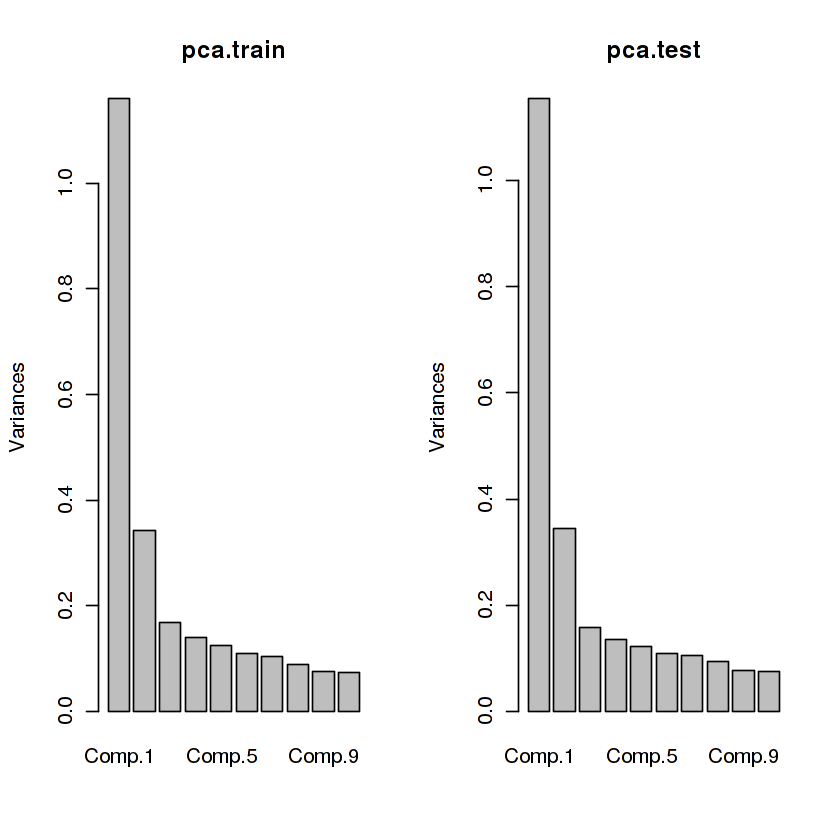

In [6]:
doPCA <- TRUE
if(doPCA){
    pca.train <- princomp(train_x)
    pca.test <- princomp(test_x)
    par(mfrow= c(1, 2))
    plot(pca.train)
    plot(pca.test)
}

## Investigate distributions between training and test feature data
Here I decided to use the Kolmogrov-Smirnov test instead of the PCA components to reassure similarities between the training and test samples.

In [7]:
options(warn = -1) # To avoid the warning prompts referring to the presence of ties
ks.res <- sapply(seq(ncol(train_x)), function(i) ks.test(train_x[, i], test_x[, i]))
q.values <- p.adjust(ks.res[2, ], method= "BH")
colnames(train_x[which(q.values <= .05)])

[1] "SPIC"

The multiple-test corrected p-values reveal that only for one TF there was a significant difference in the annotated binding affinities between the trainin and test data.

## Set the NN hyper-parameters

In [8]:
epochs <- 500
early_stop_patience <- 500
hidden_layer <- 50 #c(floor(mean(ncol(train_x), ncol(train_y))))
#hidden_layer <- c(512, 256, 128)
print("hiddenlayer info:")
print(hidden_layer)
activation_func <- c("tanh") #, "tanh", "tanh")
drop_out_rate <- .05
batch_size <- 1
val_split_ratio <- .1
l1_lambda <- l2_lambda <- .000

[1] "hiddenlayer info:"
[1] 50


## Build the NN model

In [9]:
model <- keras_model_sequential()

# build the 1st layer
layer_dense(model, units= hidden_layer[1], activation= activation_func[1], input_shape= ncol(train_x),
            kernel_regularizer= regularizer_l1_l2(l1= l1_lambda, l2= l2_lambda))
model <- layer_dropout(model, rate= drop_out_rate)

# add the other hidden layers
if(length(hidden_layer) > 1){
    for(i in seq(2, length(hidden_layer))){
        model <- layer_dense(model, units= hidden_layer[i], activation= activation_func[i],
                          kernel_regularizer= regularizer_l1_l2(l1= l1_lambda, l2= l2_lambda))
        model <- layer_dropout(model, rate= drop_out_rate)
    }
}

# finish off by adding the output layer
model <- layer_dense(model, units= ncol(train_y), activation = "tanh")

## Compile the model

In [10]:
compile(model, loss= "mse", optimizer= optimizer_rmsprop(), metrics= list("mean_absolute_error"))

## Summary of the model

In [11]:
summary(model)

________________________________________________________________________________
Layer (type)                        Output Shape                    Param #     
dense_1 (Dense)                     (None, 50)                      36350       
________________________________________________________________________________
dropout_1 (Dropout)                 (None, 50)                      0           
________________________________________________________________________________
dense_2 (Dense)                     (None, 306)                     15606       
Total params: 51,956
Trainable params: 51,956
Non-trainable params: 0
________________________________________________________________________________


## Fit the data to the built and compiled model

In [12]:
early_stop <- callback_early_stopping(monitor= "val_loss", patience= early_stop_patience)

history <- fit(model, as.matrix(train_x), as.matrix(train_y), 
               epochs= epochs, batch_size= batch_size, validation_split= val_split_ratio,
               verbose= 1, callback= list(early_stop))


## Model performance per epoch

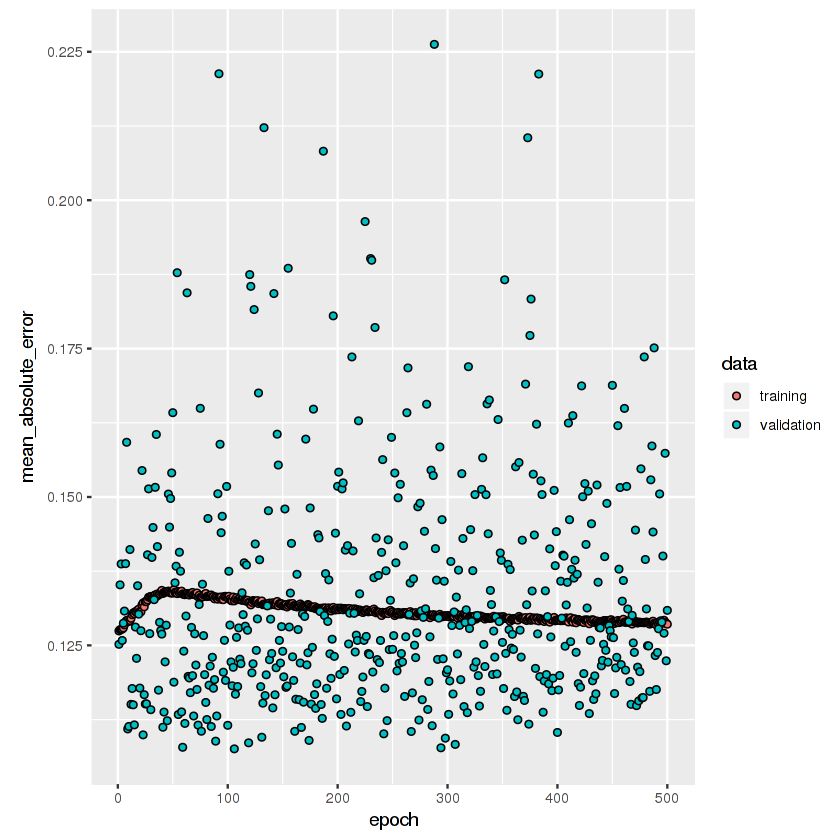

In [13]:
plot(history, metrics = "mean_absolute_error", smooth = FALSE)

## Predict the response

In [14]:
pred.train <- predict(model, as.matrix(train_x))
pred.test <- predict(model, as.matrix(test_x))

## Plot the response (perdicted and measured) on the test data (training is a lot to show)

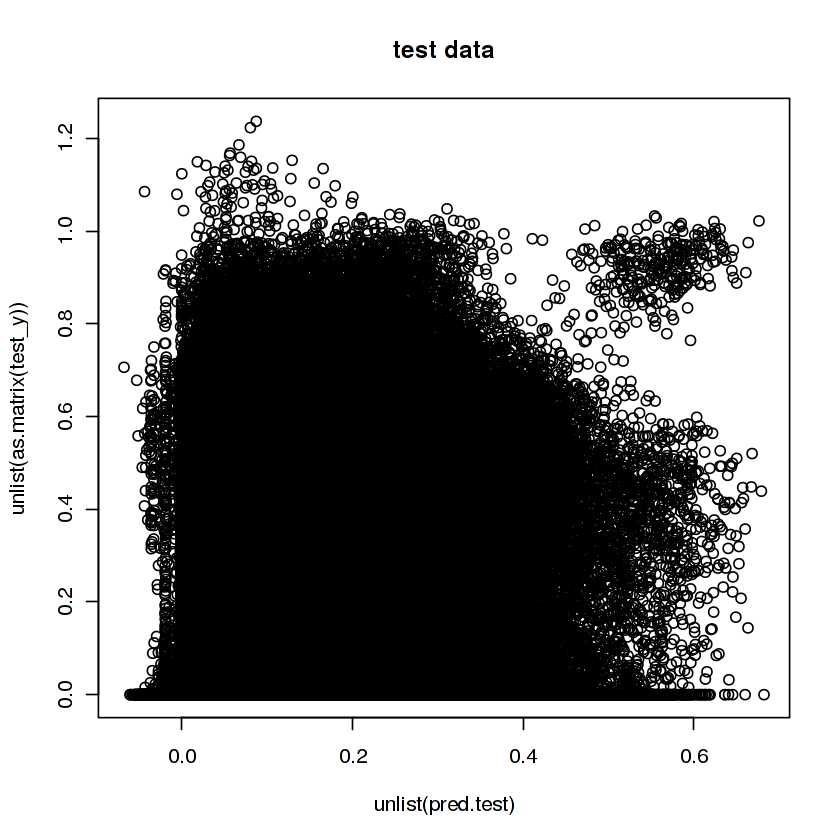

In [15]:
plot(unlist(pred.test), unlist(as.matrix(test_y)), main= "test data")

## Compute the correlation between the actual response and the predicted

In [16]:
cors.train <- sapply(seq(ncol(pred.train)), function(i) cor(pred.train[, i], train_y[, i]))
cors.test <- sapply(seq(ncol(pred.test)), function(i) cor(pred.test[, i], test_y[, i]))

## Plot the correlation histograms

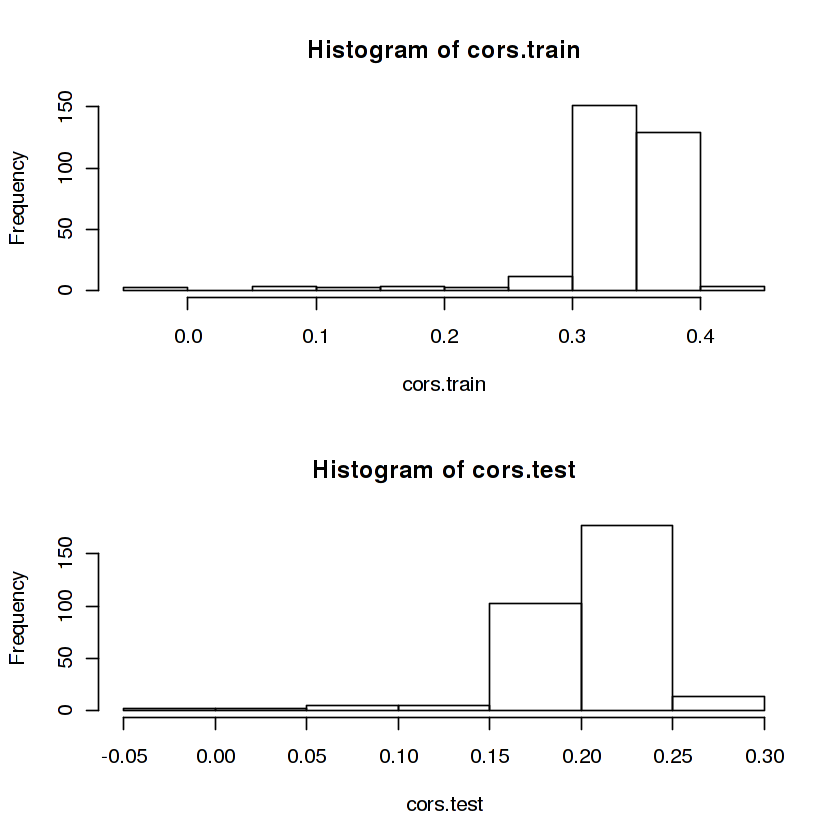

In [17]:
par(mfrow= c(2, 1))
 hist(cors.train)
 hist(cors.test)

## Get model weights

In [18]:
model_weights <- get_weights(model)
print(length(model_weights))

[1] 4


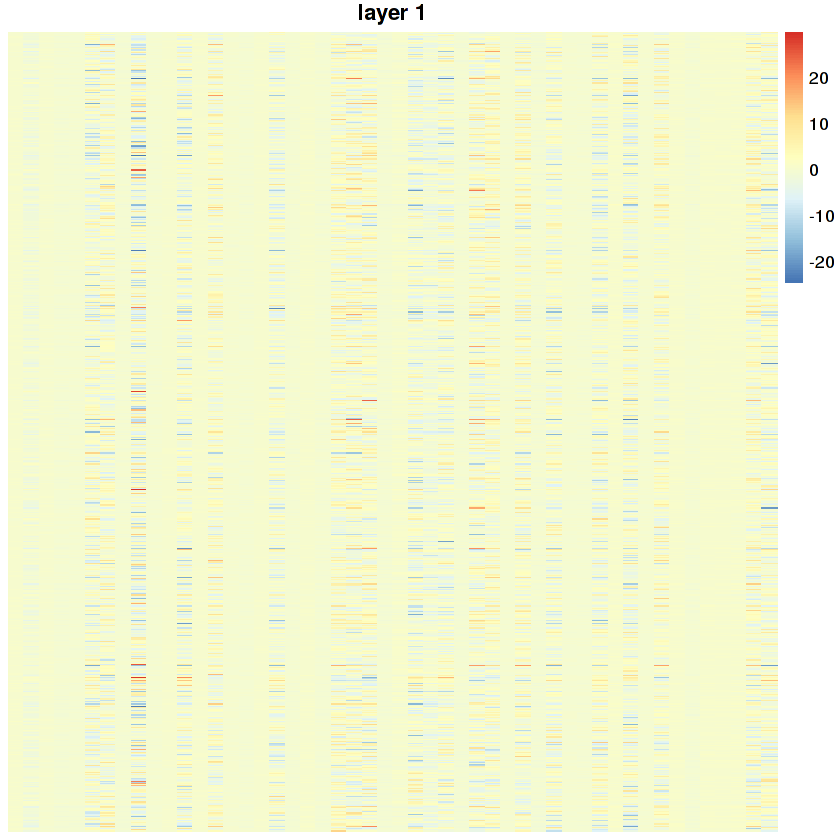

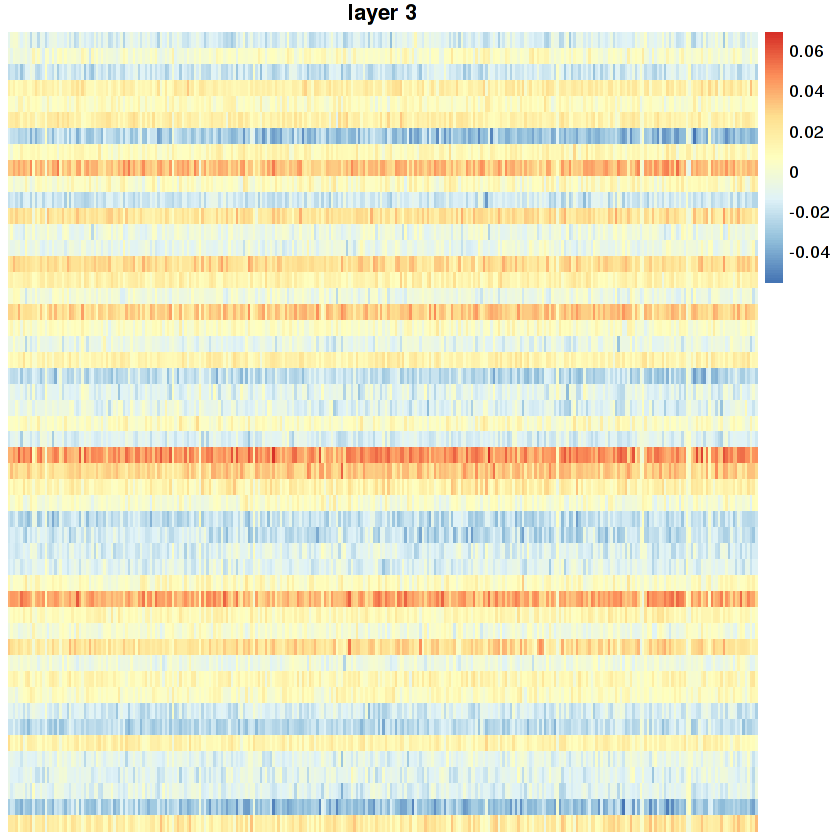

In [19]:
for(i in seq(1, length(model_weights), by= 2)) # Skipping the bias weights
    pheatmap(model_weights[[i]], cluster_rows= F, cluster_cols= F, main= paste("layer", i))

# Conclusion

* The history plot where shows the model performance per epoch for validation and training, does imply the lack of generalizablity on the unseen samples (tremendous fluctuations of the validation error throughout the epochs)
* However, the correlation results reflecting the model performance suggest similar performance of the model on the training and test data
* Given that this data was generated based on the genome version hg19, and the liver data on the hg38, I was wonderingmaybe this would be worthwhile re-visiting the data generation and preprocessing for hg38